In [2]:
import cv2
from math import gcd
import subprocess
import matplotlib.pyplot as plt
import os, shutil, glob
from skimage import measure
import numpy as np

In [3]:
data_path = '/home/dnyanada/Dropbox/data/'
infile = 'DSC_0630.JPG'
infile1 = 'DSC_0630_transform1.JPG'
infile2 = 'DSC_0630_transform2.JPG'
infile_cropped = 'DSC_0630_noBg.JPG'

In [4]:
image = cv2.imread(data_path+infile)
t1 = cv2.imread(data_path+infile1)
t2 = cv2.imread(data_path+infile2)

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(thresh, output) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(thresh)

172.0


In [6]:
#Ref  https://henrydangprg.com/2016/06/26/color-detection-in-python-with-opencv/
def detect_color(values, im):
    color = np.uint8([[[values[0], values[1], values[2]]]])
    hsv_color = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)
    hue = hsv_color[0][0][0]
    lower = np.array([hue-10, 100, 100])
    upper = np.array([hue+10, 255, 255])
    return cv2.inRange(im, lower, upper)

In [ ]:
from skimage import feature


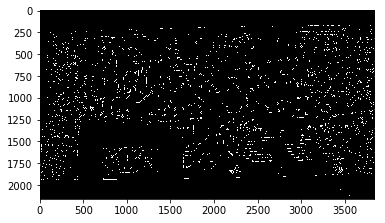

382
147
103


In [7]:
#Ref : https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html
#Good features to detect
#gets top N strongest corners in the image 

def corner_detection(input_image):
        
    gray_ = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
    (thresh_, _) = cv2.threshold(gray_, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    bw_ = cv2.threshold(gray_, thresh_+40, 255, cv2.THRESH_BINARY)[1]
    corners = cv2.goodFeaturesToTrack(bw_,25,0.01,200)
    corners = np.int0(corners)

    for i in corners:
        x,y = i.ravel()
        cv2.circle(input_image,(x,y),10,255,-1)

    plt.imshow(input_image)
    plt.show()
#Detecting corner points by finding contours
#Ref : https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
#Algorithm: Use edge detection, get an edged image, find contours, sort by area, approximate the contours 
#and if the approx curve is a quadrilateral then store then 4 points

def find_contours(input_image):
   
    #green_bgr = [83,135,98]
    #mask = detect_color(green_bgr, cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV))
    
    blur = cv2.bilateralFilter(input_image, 15, 150, 150)
    gray_ = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    #(thresh_, _) = cv2.threshold(gray_, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #bw_ = cv2.threshold(gray_, thresh_+40, 255, cv2.THRESH_BINARY)[1]
    
    
   # sobelx = cv2.Sobel(bw_,cv2.CV_64F,1,0,ksize=3) 
   # sobely = cv2.Sobel(bw_,cv2.CV_64F,0,1,ksize=3)
    
    edge = cv2.Canny(gray, 100, 200)
    #cv2.imshow('Edges',edged)
    plt.imshow(edge, cmap = 'gray')
    plt.show()
    contours = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
    #Above function returns img, contours, hierarchy(?) => We pick only contours
    #contours is a list of numpy array of coordinates
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:3] #Pick only the top 3 contours with max area
    for c in contours:
        print(len(c))
        

#corner_detection(image)
find_contours(image)

(2160, 3840, 3)


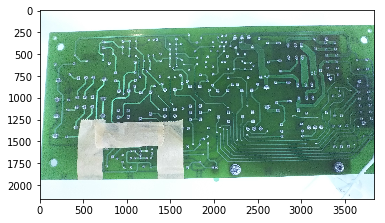

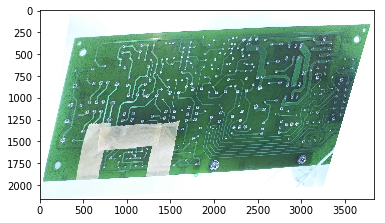

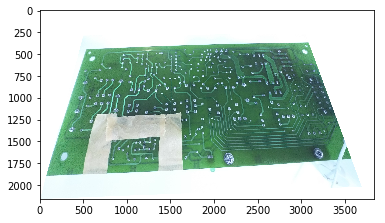

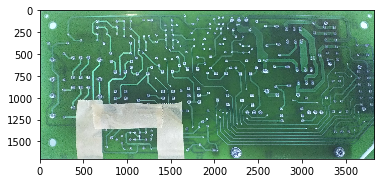

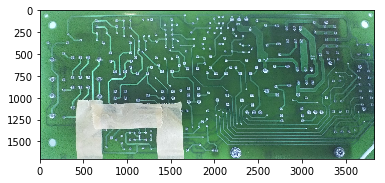

True

In [8]:
#Perspective tranformation trial
#Ref: https://pysource.com/2018/02/14/perspective-transformation-opencv-3-4-with-python-3-tutorial-13/
print((image.shape))
src1 = np.float32([[399,315],[3789,162],[36,1959], [3318,1761]])
dst = np.float32([[0,0],[3830, 0],[0, 1700],[3830, 1700]])
src2 = np.float32([[531,450],[3075,378],[78,1890],[3564,1698]])

m1 = cv2.getPerspectiveTransform(src1,dst)
m2 = cv2.getPerspectiveTransform(src2,dst)

transform1 = cv2.warpPerspective(t1, m1, (3830,1700))
transform2 = cv2.warpPerspective(t2, m2, (3830,1700))

plt.imshow(image)
plt.show()
plt.imshow(t1)
plt.show()
plt.imshow(t2)
plt.show()
plt.imshow(transform1)
plt.show()
plt.imshow(transform2)
plt.show()
cv2.imwrite(data_path+infile1[:-4]+"_out.JPG", transform1)
cv2.imwrite(data_path+infile2[:-4]+"_out.JPG", transform2)

#Inverse perspective transform 
#Ref : https://stackoverflow.com/questions/32366786/opencv-homography-matrix-h-and-inverse-h-to-transform-a-point-is-not-getting-exp
def invert_points(x, y, H):
    _, inv = cv2.invert(H)
    tx = H[0,0]*x + H[0,1]*y + H[0,2]
    ty = H[1,0]*x + H[1,1]*y + H[1,2]
    tz = H[2,0]*x + H[2,1]*y + H[2,2]
    ix = int(tx/tx)
    iy = int(ty/tz)
    
    return (ix,iy)

(ix, iy) = invert_points(0, 1700, m1)
print((ix, iy))

#Background removal
#REFERENCE: https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

#### (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

#### (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

#### (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = image[y:y+h, x:x+w]
cv2.imwrite(data_path+infile[:-4]+'_noBg.JPG', dst)

In [5]:
#image = cv2.imread(data_path+infile[:-4]+'_noBg.JPG')

In [4]:
#Width and height are inverted
factor = 4 #FIGURE OUT HOW TO FIND THIS 
width = image.shape[1]
height = image.shape[0]
crop_height = height//(gcd(width,height)//factor)
crop_width = width//(gcd(width,height)//factor)
print(gcd(width,height))

240


In [5]:
cropped = image[:crop_height,:crop_width]
cropped.shape

(36, 64, 3)

In [37]:
#Test
#cv2.imwrite(data_path+'cropped_0630.JPG',cropped)

True

In [6]:
subprocess.run(["mkdir", data_path+infile[:-4]])

CompletedProcess(args=['mkdir', '/home/dnyanada/Dropbox/data/DSC_0630_an'], returncode=0)

In [7]:
crop_path = data_path+infile[:-4]+'/'

In [8]:

#Red detection
num_squares = gcd(width,height)//factor
offset = 0
offset_list = []
#i*crop_height and range(num_squares)
size_factor = num_squares//10
while offset < num_squares:
    offset_list.append(offset)
    offset += size_factor
for o in offset_list[:1]:
    grid_count = 0
    for i in range(crop_height):
        for j in range(crop_width):
            cropped = image[i*num_squares+o:(i+1)*num_squares+o, j*num_squares+o:(j+1)*num_squares+o]
            bgr = [22,22,221]
            mask = detect_color(bgr, cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV))
            output = cv2.bitwise_and(cropped, cropped, mask = mask)
            cv2.imwrite(crop_path+infile[:-4]+'_' + 'offset'+str(o)+'_'+str(grid_count)+'.JPG', mask)
            grid_count += 1
        
total_images = crop_width*crop_height

In [208]:
num_squares = gcd(width,height)//factor
offset = 0
offset_list = []
#i*crop_height and range(num_squares)
size_factor = num_squares//10
while offset < num_squares:
    offset_list.append(offset)
    offset += size_factor
for o in offset_list[:1]:
    grid_count = 0
    for i in range(crop_height):
        for j in range(crop_width):
            cropped = image[i*num_squares+o:(i+1)*num_squares+o, j*num_squares+o:(j+1)*num_squares+o]
            cv2.imwrite(crop_path+infile[:-4]+'_' + 'offset'+str(o)+'_'+str(grid_count)+'.JPG', cropped)
            grid_count += 1
        
total_images = crop_width*crop_height


In [22]:
ext = '.JPG'
prefix = crop_path+infile[:-(len(ext))]+"_offset"
#NAMING FORMAT: prefix+offset+'_'+gridcount+ext
test = [254,284,274,293,322,429,504]


In [25]:
name = prefix+'0_'+str(981)
red = cv2.imread(name+ext)

/home/dnyanada/Dropbox/data/DSC_0630_an/DSC_0630_an_offset0_981
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


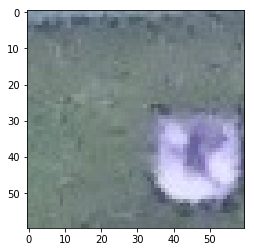

SHAPE:  (60, 60)


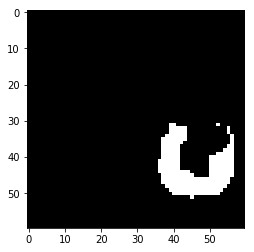

[[254 255 255 ... 255 255 255]
 [255 253 255 ... 255 255 255]
 [255 254 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [210]:
#Single image test
#Convert to black and white using Otsu's algorithm
#Reference: https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white
#The problem with Otsu threshold on sub-image: Takes intensities relatively, might accidentally assign a white color to some random spot in the centre of the image
#Try using thresholding on the entire image and use that threshold value for subimages.
name = prefix+'0'+'_'+str(340)
original = cv2.imread(name+ext)
#original = cv2.GaussianBlur(original,(3,3),0)
gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
plt.imshow(original)
plt.show()

output = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]

#This: check
output = 255 - output 
kernel = np.ones((3,3),np.float32)
kernel[1][1] = 0
dst = cv2.filter2D(output,-1,kernel)
dst = 255 - dst

print("SHAPE: ", output.shape)
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_GRAY2BGR))
plt.show()
print(bw)
cv2.imwrite(name+'.bw'+ext, output)
bw = cv2.imread(name+'.bw'+ext,0)


In [211]:
#Blob detection
#Reference : https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/
def isBlob(bw):
    #Control parameter: Min number of pixels to be classified as blob
    min_pix = bw.shape[0]*bw.shape[1]//150 #1% if total number of pixels
    #kernel = None #np.ones((1,1),np.uint8)#default is 3x3
    #blob = cv2.erode(bw, kernel, iterations=1)
    #blob = cv2.dilate(blob, kernel, iterations=1)
    numPixels = cv2.countNonZero(bw)
    if numPixels >= min_pix:
        return True
    else:
        return False

#Algorithm for background detection
#Count number of white pixels in each boundary as you move inwards and set some threshold for acceptance
#using the image rotation algorithm to count white pixels
def accepted(imfile):
    
    original = cv2.imread(imfile)
    if original.shape != (60,60,3):
        return False
    #New lines: image smoothening
    gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    bw = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
    
    bw = 255 - bw 
    kernel = np.ones((3,3),np.float32)
    kernel[1][1] = 0
    bw = cv2.filter2D(bw,-1,kernel)
    bw = 255 - bw
    
    if imfile == '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset30_240.JPG':
        plt.imshow(cv2.cvtColor(bw,cv2.COLOR_GRAY2BGR))
        plt.show()
    #Control parameters
    backgr_thresh = 2
    upper_layers = 3
    avg_layer_pixels = 5
    n = bw.shape[0]
    
    layer_count = []
    for layer in range(0,upper_layers):
        sum_pixel =0
        for i in range(layer, n-layer-1):
            last = n-layer-1
            sum_pixel += bw[layer][i] + bw[i][last] + bw[last][n-i-1] + bw[n-i-1][layer]
        layer_count.append(sum_pixel/255)
        if imfile == '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_340.JPG':
            print("Layer : {0}, Sum : {1}".format(layer, sum_pixel/255))
    
    #TODO : rewrite using sum(). Check that's wrong with that
        
    total_upper = 0
    for i in layer_count:
        total_upper += i
    if imfile == '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_284.JPG':
        print("Total : ",total_upper)
    #Partial solder case
    if layer_count[0] or total_upper/upper_layers >= backgr_thresh:
        return False
    else:
        return isBlob(bw)
    
accepted_images = []
print("Accepted? ", accepted(name+ext))
for o in offset_list[:1]:
    for i in range(total_images):
        filename = prefix+str(o)+'_'+str(i)+ext
        if accepted(filename):
                accepted_images.append(filename)
print(accepted_images[:20])

#'/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_247.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_248.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_249.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_250.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_251.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_269.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_276.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_284.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_293.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_294.JPG']

Accepted?  True


/home/dnyanada/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in ubyte_scalars


['/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_284.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_293.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_294.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_340.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_341.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_342.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_358.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_372.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_427.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_429.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_438.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_440.JPG', '/home/dnyanada/Dropbox/data/DSC_0630_blue/DSC_0630_blue_offset0_500.JPG', '/home/dnyanada/Dropbox/

In [212]:
#Copy images into another folder
filtered = crop_path+'Filtered/'
shutil.rmtree(filtered)
os.makedirs(filtered)
for f in accepted_images:
    shutil.copy(f, filtered)

In [33]:
#Enhance contrast of color image
#Reference : https://chrisalbon.com/machine_learning/preprocessing_images/enhance_contrast_of_color_image/
#Reference: https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html

# Histogram equalization: stretched distribution, 
#i.e. most of the pixel values are concentrated around the average.
#Stretching => make some light pixels lighter and dark pixels darker :. contrast improves
#For color, we convert to YUV cause it helps change intensity without affecting color much
for i in test:
    name = prefix+'0_'+str(i)
    original = cv2.imread(name+ext)
    #Denoising before contrasting - using default values, refer docs
    denoise = cv2.fastNlMeansDenoisingColored(original, None, 2,2,7,21)
    cv2.imwrite(name+'.denoise'+ext, denoise)
    
    #Adds contrast
    #TODO : find a better way, this adds too much contrast
    image_yuv = cv2.cvtColor(denoise, cv2.COLOR_BGR2YUV)
    image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
    image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    cv2.imwrite(name+'.contr'+ext, image_rgb)
    

In [ ]:
#Remove the test files
for file in glob.glob(os.path.join(crop_path, "*.gray.JPG")):
    os.remove(file)

In [9]:
import pytesseract
from PIL import Image

In [10]:
infile = data_path+'text.JPG'

In [13]:
result = pytesseract.image_to_string(Image.open(infile))
print(result)